# 模型列表

In [2]:
import os
import pandas as pd
#PEMSD3
# model_list = [
#     'mask/mySTGCN_12394',
# #     'mask/HGCN_85983',
#     'mask/TGCN_32485',
#     'mask/DCRNN_13790',
#     'mask/MTGNN_23261',
#     'mask/GTS_80395'
# ]

# 这个是对GTS调整后的版本
# PEMSD4 = [
#     'mask/mySTGCN_6296',
#     'mask/TGCN_27287',
#     'mask/DCRNN_5521',
#     'mask/GTS_45622',
#     'mask/MTGNN_99863'
# ]
# PEMSD8 = [
#     'mask/mySTGCN_18153',
#     'mask/TGCN_22291',
#     'mask/DCRNN_97181',
#     'mask/GTS_35808',
#     'mask/MTGNN_60633'    
# ]
# TGESHD = [
#     'mask/mySTGCN_96334',
#     'mask/TGCN_246',
#     'mask/DCRNN_63585',
#     'mask/MTGNN_42631',
# ]

# 相关性分析的实验数据，来自提交435184f8494c2ccd00238c09daeadbf2de311e78
PEMSD4 = [
    'mask/mySTGCN_6296',
    'mask/TGCN_27287',
    'mask/DCRNN_5521',
    'mask/GTS_75434',
    'mask/MTGNN_64178'
]

PEMSD8 = [
    'mask/mySTGCN_18153',
    'mask/TGCN_22291',
    'mask/DCRNN_97181',
    'mask/GTS_27251',
    'mask/MTGNN_99167'    
]
TGESHD = [
    'mask/mySTGCN_13553',
    'mask/TGCN_246',
    'mask/DCRNN_63585',
    'mask/MTGNN_13012',
]
model_lists=[PEMSD4,PEMSD8,TGESHD]
device='cpu'

ACCs=[]
for model_list in model_lists:
    ACC=[]
    for model in model_list:
        exp_id=model.split('_')[1]
        path=f"../lib/Bigscity-LibCity/libcity/cache/{exp_id}/evaluate_cache"
        csv_name=''
        for fname in os.listdir(path):
            if fname[-3:]=='csv' and fname.find('烂数据')==-1:
                csv_name=fname
                break
        df=pd.read_csv(path+'/'+csv_name)
        ACC.append(df['masked_RMSE'][0])
    print(ACC)
    ACCs.append(ACC)

[15.503549575805664, 22.215839385986328, 16.320024490356445, 16.100595474243164, 15.92845058441162]
[11.506980895996094, 16.856281280517578, 12.629844665527344, 12.01823616027832, 11.856420516967772]
[3.818805456161499, 4.386194705963135, 3.944333553314209, 3.9246129989624015]


# 读取文件

In [3]:
import pickle
import numpy as np
import torch

masks_groups=[]
for model_list in model_lists:
    adj=None
    with open(f'../data/{model_list[0]}/adj.pkl','rb') as f:
        adj=torch.from_numpy(pickle.load(f)).to(device)
    
    mask_list=[]
    mask2_list=[]
    fmask_list=[]
    gen_mask_list=[]

    for model in model_list:
        mask=None
        mask2=None
        fmask=None

        with open(f'../data/{model}/mask.pkl','rb') as f:
            mask=torch.from_numpy(pickle.load(f)).to(device)
        with open(f'../data/{model}/mask2.pkl','rb') as f:
            mask2=torch.from_numpy(pickle.load(f)).to(device)
        with open(f'../data/{model}/fmask.pkl','rb') as f:
            fmask=torch.from_numpy(pickle.load(f)).to(device)

        mask=torch.relu(mask)
        mask=adj*(mask+mask.T)/2
        mask2=torch.relu(mask2)
        mask2=adj*(mask2+mask2.T)/2
        fmask=torch.relu(fmask)

        mask_list.append(mask)
        mask2_list.append(mask2)
        fmask_list.append(fmask)
        gen_mask_list.append(mask@mask2)

    masks_groups.append([
        torch.stack(mask_list),
        torch.stack(mask2_list),
        torch.stack(fmask_list),
        torch.stack(gen_mask_list)
    ])    

# 计算平均mask、mask方差、mask离散系数

In [4]:
cv_groups=[]
var_groups=[]
avg_groups=[]
for masks_group in masks_groups:
    avg_group=[]
    var_group=[]
    cv_group=[]
    for masks in masks_group:
        avg_group.append(torch.mean(masks,0))
        var_group.append(torch.var(masks,0))
        cv=torch.sqrt(torch.var(masks,0))/torch.mean(masks,0)
        cv[torch.isnan(cv)]=0
        cv_group.append(cv)
    avg_groups.append(avg_group)
    var_groups.append(var_group)
    cv_groups.append(cv_group)

In [5]:
for i,cv_group in enumerate(cv_groups):
    for j,cv in enumerate(cv_group):
        seq=cv.reshape(-1)
        seq=seq[seq!=0]
        print(len(seq))
        print(cv.sum()/len(seq))
        print((var_groups[i][j].sum()/len(seq))/(avg_groups[i][j].sum()/len(seq)))
    print('=================')

680
tensor(0.2173)
tensor(0.0529)
680
tensor(0.2239)
tensor(0.0577)
3684
tensor(0.1520)
tensor(0.0274)
1335
tensor(0.3147)
tensor(0.1620)
548
tensor(0.1682)
tensor(0.0338)
548
tensor(0.1679)
tensor(0.0354)
2040
tensor(0.1185)
tensor(0.0197)
1542
tensor(0.2285)
tensor(0.1062)
13406
tensor(0.1552)
tensor(0.0298)
13406
tensor(0.2342)
tensor(0.0640)
53988
tensor(0.1402)
tensor(0.0237)
31853
tensor(0.2631)
tensor(0.1243)


# 计算残差和皮尔逊相关系数

In [6]:
from copy import deepcopy
import scipy.stats
def normalization(data):
    _range = torch.max(data) - torch.min(data)
    return (data - torch.min(data)) / _range
dist_groups=[]
for no,masks_group in enumerate(masks_groups):
    dist_group=[]
    for i in range(len(masks_group)):
        dist_group.append(list(torch.abs(masks_group[i]-avg_groups[no][i]).sum(dim=(1,2))))
    print(dist_group[0])#mask1
    print(dist_group[1])#mask2
    print(dist_group[2])#fmask
    print(dist_group[3])#genmask

    # normalized_acc=normalization(torch.tensor(ACCs[no]))
    acc=list(torch.tensor(ACCs[no]))
    dist_group.append(acc)
    
    a=deepcopy(acc)
    b=deepcopy(dist_group)
#     a.pop(1)
#     b[0].pop(1)
#     b[1].pop(1)
#     b[2].pop(1)
#     b[3].pop(1)
    print(np.corrcoef(a, b[0]))
    print(np.corrcoef(a, b[1]))
    print(np.corrcoef(a, b[2]))
    print(np.corrcoef(a, b[3]))
    
    print(scipy.stats.spearmanr(a, b[0]))
    print(scipy.stats.spearmanr(a, b[1]))
    print(scipy.stats.spearmanr(a, b[2]))
    print(scipy.stats.spearmanr(a, b[3]))
    dist_groups.append(dist_group)


[tensor(64.9597), tensor(168.8762), tensor(62.1197), tensor(140.7778), tensor(64.4529)]
[tensor(61.5245), tensor(176.9547), tensor(56.8682), tensor(156.7764), tensor(66.5884)]
[tensor(217.3867), tensor(753.1652), tensor(233.8864), tensor(355.4633), tensor(309.7418)]
[tensor(230.1191), tensor(554.9692), tensor(202.4126), tensor(622.5929), tensor(206.3402)]
[[1.         0.76713869]
 [0.76713869 1.        ]]
[[1.        0.7168357]
 [0.7168357 1.       ]]
[[1.         0.96992314]
 [0.96992314 1.        ]]
[[1.         0.53268965]
 [0.53268965 1.        ]]
SignificanceResult(statistic=0.3, pvalue=0.6238376647810728)
SignificanceResult(statistic=0.39999999999999997, pvalue=0.5046315754686911)
SignificanceResult(statistic=0.7, pvalue=0.1881204043741873)
SignificanceResult(statistic=0.09999999999999999, pvalue=0.8728885715695383)
[tensor(37.5234), tensor(115.0790), tensor(36.6654), tensor(76.8605), tensor(51.9058)]
[tensor(33.8135), tensor(110.9744), tensor(42.0699), tensor(94.0522), tensor(43

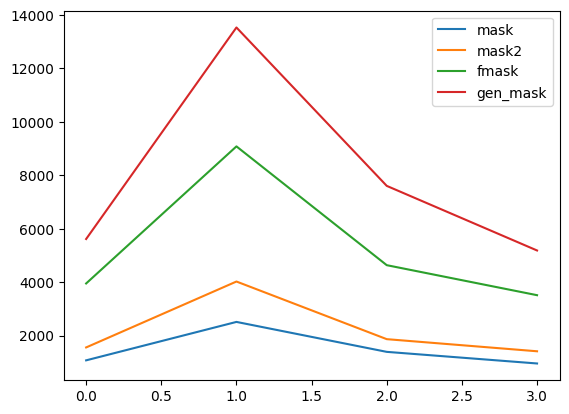

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
x=[i for i in range(len(model_list))]
plt.plot(x,dist_group[0],label="mask")
plt.plot(x,dist_group[1],label="mask2")
plt.plot(x,dist_group[2],label="fmask")
plt.plot(x,dist_group[3],label="gen_mask")
#plt.plot(x,normalized_acc,label="accurancy")
plt.legend()

In [7]:
PeMSD4_list=list(dist_groups[0])
PeMSD8_list=list(dist_groups[1])
TGESHD_list=list(dist_groups[2])

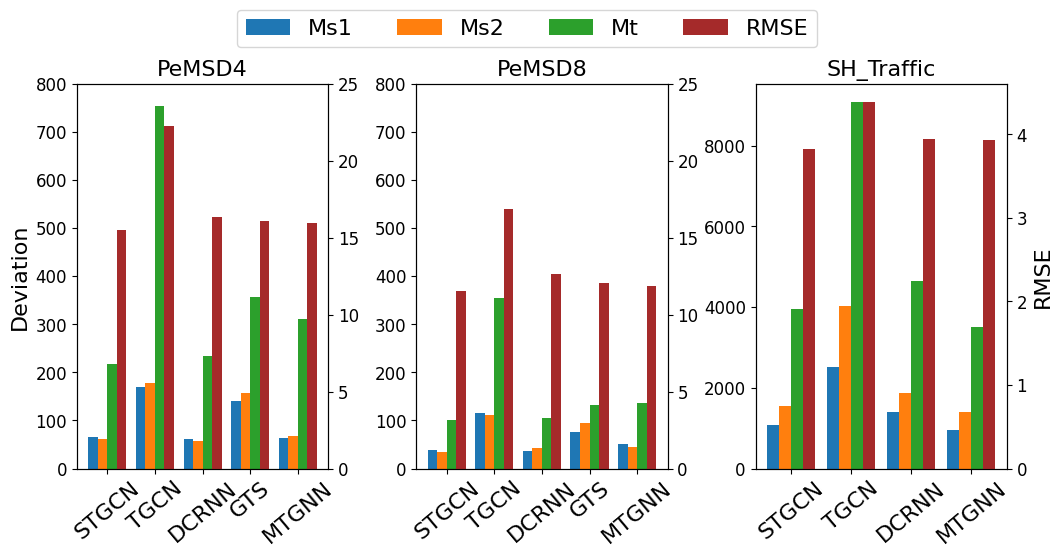

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# 构造x轴刻度标签、数据
data=[PeMSD4_list,PeMSD8_list,TGESHD_list]
title=['PeMSD4','PeMSD8','SH_Traffic']
labels = [['STGCN', 'TGCN', 'DCRNN', 'GTS', 'MTGNN'],
          ['STGCN', 'TGCN', 'DCRNN', 'GTS', 'MTGNN'],
          ['STGCN', 'TGCN', 'DCRNN', 'MTGNN']]

fig = plt.figure(figsize=(12, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.35)
axes = fig.subplots(nrows=1, ncols=3)
for no,ax1 in enumerate(axes):
    x = np.arange(len(labels[no]))  # x轴刻度标签位置
    width = 0.2  # 柱子的宽度
    # 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
    b1 = ax1.bar(x - 1.5*width, data[no][0], width, label='Ms1')
    b2 = ax1.bar(x - 0.5*width, data[no][1], width, label='Ms2')
    b3 = ax1.bar(x + 0.5*width, data[no][2], width, label='Mt')
    if no==0:
        ax1.set_ylabel('Deviation', fontsize=16)
    if no!=2:
        ax1.set_ylim(0,800)
    ax1.set_title(title[no], fontsize=16)
    # x轴刻度标签位置不进行计算
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels[no], fontsize=16, rotation=40)
    for y in ax1.get_yticklabels():
        y.set_fontsize(12)
    
    ax2 = ax1.twinx()
    b4 = ax2.bar(x + 1.5*width, data[no][-1], width, label='RMSE', color = 'brown')
    if no==2:
        ax2.set_ylabel('RMSE', fontsize=16)
    else:
        ax2.set_ylim(0,25)
    for y in ax2.get_yticklabels():
        y.set_fontsize(12)
fig.legend(handles = [b1,b2,b3,b4], bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=4, prop = {'size':16})
# 设置不显示边框
plt.savefig('../img/corrcoef.pdf', bbox_inches = 'tight')  
plt.show()